## Step 2: Mounting Google Drive and Loading the Trained Model

This section mounts Google Drive to access stored files and loads the pretrained FastAI model (`shoe_model.pkl`). The model is essential for making predictions on new shoe images without retraining from scratch. A confirmation message indicates successful loading.

In [2]:
from fastai.vision.all import *

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/shoe_model.pkl'
learn = load_learner(path)

print("Model loaded successfully!")

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Model loaded successfully!


## Step 3: Making Predictions with the Model

We load a sample test image and pass it through the pretrained model to predict its class (Shoe, Sandal, or Boot). The model returns the predicted label, index, and associated probabilities. The image is then displayed with the predicted class and confidence score for visual confirmation.


Predicted class: Sandal
Probability: 1.0000


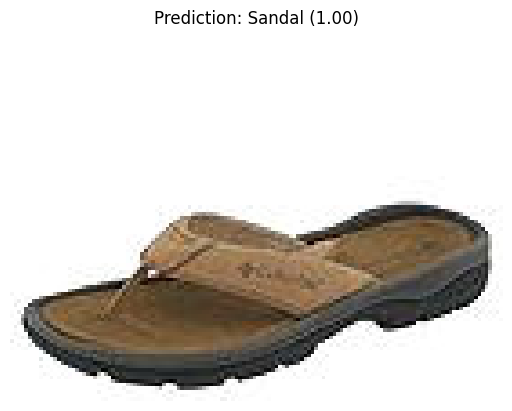

In [ ]:
img = PILImage.create("/content/drive/MyDrive/ColabNotebooks/projects/Shoe Classifier/shoe_test/Sandal (222).jpg")  # Replace with any image path
pred_class, pred_idx, probs = learn.predict(img)

print(f'Predicted class: {pred_class}')
print(f'Probability: {probs[pred_idx]:.4f}')

plt.imshow(img)
plt.title(f"Prediction: {pred_class} ({probs.max():.2f})")
plt.axis('off')
plt.show()

Predicted Class: Shoe
Probability: 1.0000


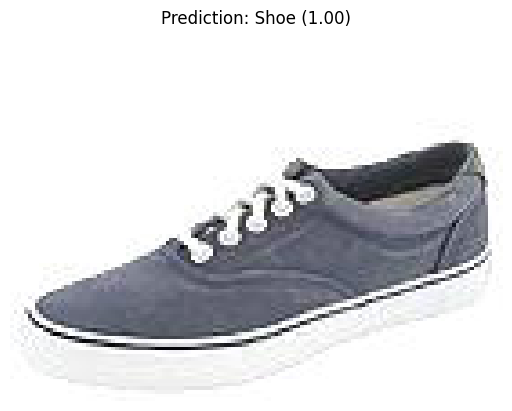

In [ ]:
img = PILImage.create("/content/drive/MyDrive/ColabNotebooks/projects/Shoe Classifier/shoe_test/Shoe (42).jpg")  # Replace with any image path
pred_class, pred_idx, probs = learn.predict(img)

print(f"Predicted Class: {pred_class}")
print(f"Probability: {probs[pred_idx]:.4f}")

# Display images with predictions
plt.imshow(img)
plt.title(f'Prediction: {pred_class} ({probs.max():.2f})')
plt.axis('off')
plt.show()


## Color extraction and storing every color as metadata.

## Step 4: Background Removal and Dominant Color Extraction

This section enhances prediction output by analyzing the dominant color of the footwear while excluding background noise. Using the `rembg` library, we first remove the background from each image, then apply KMeans clustering on the segmented region to determine the most prominent color. Each image is classified by the model, and the predicted class and dominant color are stored for further analysis or visualization.

Note: We filter out pure black pixels ([0, 0, 0]) to avoid skewing the color detection due to background remnants.


In [1]:
!pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 971.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.2 MB/s eta 0:00:00


In [4]:
!pip install -q onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00


In [5]:
from fastai.vision.all import load_learner
from rembg import remove
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import numpy as np
import os
import io

# Load your trained FastAI model
model = load_learner('/content/drive/My Drive/shoe_model.pkl')

# Function to extract the dominant color after background removal
def extract_dominant_color(image_path, k=3):
    with open(image_path, "rb") as f:
        input_image = f.read()

    # Remove background
    output_image = remove(input_image)
    img = Image.open(io.BytesIO(output_image)).convert("RGB")
    img = img.resize((100, 100))  # Resize to speed up KMeans

    # Convert to numpy and remove black/transparent background
    img_np = np.array(img)
    pixels = img_np.reshape(-1, 3)
    pixels = pixels[np.any(pixels != [0, 0, 0], axis=1)]

    if len(pixels) == 0:
        return (0, 0, 0)  # fallback if segmentation failed

    # Run KMeans
    kmeans = KMeans(n_clusters=k, n_init='auto')
    labels = kmeans.fit_predict(pixels)
    counts = np.bincount(labels)
    dominant_idx = counts.argmax()
    return tuple(kmeans.cluster_centers_[dominant_idx].astype(int))

# Directory where test images are located
image_dir = "/content/drive/MyDrive/ColabNotebooks/projects/Shoe Classifier/shoe_test"

# Store results
results = []

# Loop through all images and process
for fname in os.listdir(image_dir):
    fpath = os.path.join(image_dir, fname)
    if os.path.isfile(fpath):
        try:
            pred_class, _, _ = model.predict(fpath)
            dominant_color = extract_dominant_color(fpath)

            results.append({
                'image': fpath,
                'predicted_class': str(pred_class),
                'dominant_color': dominant_color
            })

            print(f"Processed: {fname} | Class: {pred_class} | Color: {dominant_color}")

        except Exception as e:
            print(f"Error processing {fname}: {e}")


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 194GB/s]


Processed: boot (1053).jpg | Class: Boot | Color: (np.int64(215), np.int64(108), np.int64(173))


Processed: boot (1254).jpg | Class: Boot | Color: (np.int64(244), np.int64(115), np.int64(129))


Processed: boot (1260).jpg | Class: Boot | Color: (np.int64(63), np.int64(68), np.int64(80))


Processed: boot (14).jpg | Class: Boot | Color: (np.int64(74), np.int64(77), np.int64(83))


Processed: boot (15).jpg | Class: Boot | Color: (np.int64(3), np.int64(3), np.int64(3))


Processed: boot (16).jpg | Class: Boot | Color: (np.int64(136), np.int64(80), np.int64(73))


Processed: boot (269).jpg | Class: Boot | Color: (np.int64(119), np.int64(110), np.int64(109))


Processed: boot (29).jpg | Class: Boot | Color: (np.int64(125), np.int64(66), np.int64(51))


Processed: boot (306).jpg | Class: Boot | Color: (np.int64(167), np.int64(151), np.int64(156))


Processed: boot (32).jpg | Class: Boot | Color: (np.int64(247), np.int64(216), np.int64(149))


Processed: boot (347).jpg | Class: Boot | Color: (np.int64(210), np.int64(182), np.int64(146))


Processed: boot (40).jpg | Class: Boot | Color: (np.int64(157), np.int64(91), np.int64(89))


Processed: boot (41).jpg | Class: Boot | Color: (np.int64(52), np.int64(52), np.int64(51))


Processed: boot (552).jpg | Class: Boot | Color: (np.int64(248), np.int64(58), np.int64(71))


Processed: boot (55).jpg | Class: Boot | Color: (np.int64(136), np.int64(64), np.int64(90))


Processed: Sandal (111).jpg | Class: Sandal | Color: (np.int64(231), np.int64(228), np.int64(208))


Processed: Sandal (122).jpg | Class: Sandal | Color: (np.int64(240), np.int64(237), np.int64(218))


Processed: Sandal (174).jpg | Class: Sandal | Color: (np.int64(8), np.int64(8), np.int64(8))


Processed: Sandal (175).jpg | Class: Sandal | Color: (np.int64(11), np.int64(11), np.int64(11))


Processed: Sandal (179).jpg | Class: Sandal | Color: (np.int64(203), np.int64(70), np.int64(71))


Processed: Sandal (222).jpg | Class: Sandal | Color: (np.int64(77), np.int64(68), np.int64(55))


Processed: Sandal (28).jpg | Class: Sandal | Color: (np.int64(165), np.int64(225), np.int64(230))


Processed: Sandal (570).jpg | Class: Sandal | Color: (np.int64(182), np.int64(69), np.int64(80))


Processed: Sandal (584).jpg | Class: Sandal | Color: (np.int64(73), np.int64(73), np.int64(73))


Processed: Sandal (600).jpg | Class: Sandal | Color: (np.int64(216), np.int64(197), np.int64(171))


Processed: Sandal (607).jpg | Class: Sandal | Color: (np.int64(226), np.int64(158), np.int64(115))


Processed: Shoe (196).jpg | Class: Shoe | Color: (np.int64(29), np.int64(102), np.int64(165))


Processed: Shoe (230).jpg | Class: Shoe | Color: (np.int64(228), np.int64(206), np.int64(224))


Processed: Shoe (393).jpg | Class: Shoe | Color: (np.int64(234), np.int64(180), np.int64(123))


Processed: Shoe (45).jpg | Class: Shoe | Color: (np.int64(7), np.int64(8), np.int64(8))


Processed: Shoe (46).jpg | Class: Shoe | Color: (np.int64(7), np.int64(7), np.int64(7))


Processed: Shoe (5).jpg | Class: Shoe | Color: (np.int64(92), np.int64(45), np.int64(34))


Processed: Shoe (500).jpg | Class: Shoe | Color: (np.int64(192), np.int64(30), np.int64(33))


Processed: Shoe (633).jpg | Class: Shoe | Color: (np.int64(120), np.int64(120), np.int64(159))


Processed: Shoe (701).jpg | Class: Shoe | Color: (np.int64(248), np.int64(181), np.int64(77))


Processed: Shoe (86).jpg | Class: Shoe | Color: (np.int64(221), np.int64(135), np.int64(124))


Processed: Shoe (42).jpg | Class: Shoe | Color: (np.int64(105), np.int64(107), np.int64(119))


In [7]:
import json

# Convert numpy data types to native Python types recursively
def convert_np_types(obj):
    if isinstance(obj, dict):
        return {k: convert_np_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_np_types(i) for i in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_np_types(i) for i in obj)
    elif hasattr(obj, 'item'):  # numpy scalar
        return obj.item()
    else:
        return obj

clean_results = convert_np_types(results)

# Save results to JSON file
json_path = '/content/drive/MyDrive/ColabNotebooks/projects/Shoe Classifier/clean_results.json'
with open(json_path, 'w') as f:
    json.dump(clean_results, f)